In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

warnings.filterwarnings("ignore")

df_inbound=pd.read_csv("df_inprice.csv")
df_demand=pd.read_csv("df_demand.csv")
df_outprice=pd.read_csv("df_outprice.csv")

df_inbound=df_inbound.iloc[:, 1:]
df_outprice=df_outprice.iloc[:, 1:]
df_demand=df_demand.iloc[:, 1:]

In [3]:
df_demand

,STORE,DEMAND
0,D1,244
1,D2,172
2,D3,124
3,D4,90
4,D5,158
...,...,...
195,D196,57
196,D197,52
197,D198,243
198,D199,70


In [4]:
# 1. Initiliaze Class
model = LpProblem("Transhipment_Problem", LpMinimize)

# 2. Define Decision Variables
# Inbound Flows
I = LpVariable.dicts("I", [(i+1,j+1) for i in range(2) for j in range(2)],
                     lowBound=0, upBound=None, cat='Integer') # I(i,j) from plant i for platform j
# Outbound Flows
O = LpVariable.dicts("O", [(i+1,j+1) for i in range(2) for j in range(200)],
                     lowBound=0, upBound=None, cat='Integer') # O(i,j) from platform i for customer j

In [5]:
df_inbound

,FROM,D1,D2
0,P1,3.0,5.0
1,P2,2.3,6.6


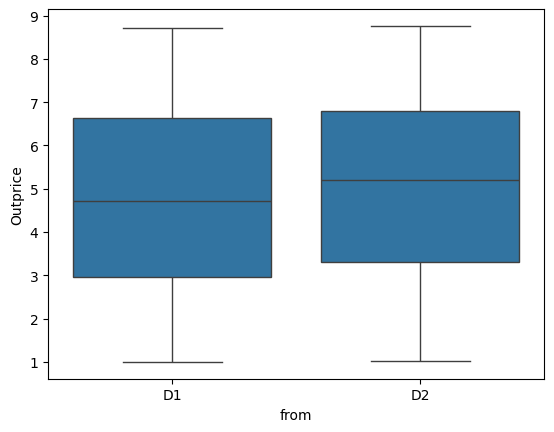

In [6]:
df_melted = df_outprice.melt(id_vars=['from'], var_name='Shop ID', value_name='Outprice')
sns.boxplot(data=df_melted,x="from", y="Outprice");

In [7]:
# 3. Define Objective Function
# Total Transportation Cost
model += lpSum([df_inbound.iloc[i,j+1] * I[i+1,j+1] for i in range(2) for j in range(2)]) + lpSum([df_outprice.iloc[i,j+1] * O[i+1,j+1] for i in range(2) for j in range(200)]) 

In [8]:
# 4. Define Constraints
# Max capacity for plants
# Supply >= demand per store
for j in range(200):
    model += lpSum([O[i+1, j+1] for i in range(2)]) >= df_demand.loc[j,'DEMAND']
# Conservation of the flow in the local DC (X-Docking Platform)
for p in range(2):
    model += lpSum([I[i+1, p+1] for i in range(2)]) == lpSum([O[p+1, j+1] for j in range(200)])

In [9]:
status=model.solve()
print(LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/hippolyteguigon/mambaforge/envs/supply_planning_optimization_enviro/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/h3/dhx473_d22lf25hhg2vdtk080000gn/T/2088917f9a694b48ac23c5a7b64e4591-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/h3/dhx473_d22lf25hhg2vdtk080000gn/T/2088917f9a694b48ac23c5a7b64e4591-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 207 COLUMNS
At line 2224 RHS
At line 2427 BOUNDS
At line 2832 ENDATA
Problem MODEL has 202 rows, 404 columns and 804 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 217189 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 217189 to -1.79769e+3

In [117]:
print("Objective: z* = {}".format(value(model.objective)))

# Matrix result
inbound, outbound = np.zeros([2,2]), np.zeros([2,200])
for i in range(2):
    for j in range(2):
        inbound[i, j] = I[i+1, j+1].varValue
for i in range(2):
    for j in range(200):
        outbound[i, j] = O[i+1, j+1].varValue

Objective: z* = 217189.3199999999


In [118]:
inbound

array([[    0.,  6232.],
       [25574.,     0.]])

In [124]:
outbound

array([[244., 172., 124.,  90., 158., 175.,   0., 223., 123.,   0.,  26.,
        286., 296.,   0.,   0., 265., 123., 246., 122., 118., 114., 259.,
        261.,  79., 297., 150., 201., 284.,   0., 289., 160., 185., 241.,
        218.,   0.,  61.,  69., 193.,  58.,  80.,   0., 136., 190., 187.,
        280.,  18., 138., 259.,  49.,  16., 221., 156.,  61., 252., 249.,
         97.,  21.,  89.,  16., 191., 290., 269., 162., 243., 280.,   0.,
         28., 281.,   0., 116., 183., 259.,   0.,  29.,  15., 112., 277.,
          0.,  18.,   0., 129.,  82., 284., 128., 183.,   0., 298., 158.,
        257.,   0., 118., 193.,  59.,  67.,   0.,   0.,  96., 148.,  98.,
        214., 270.,   0., 121.,   0., 106.,   0., 225., 152.,  69.,  40.,
        176.,  32.,  31.,  64.,  77., 101., 180.,   0., 155.,   0., 199.,
         93.,  60., 205.,  19., 140.,  91., 184., 271.,   0., 165., 248.,
        192., 130., 213.,   0.,  31., 214., 122.,   0., 225., 130.,   0.,
        128., 217., 270.,   0., 109., 

In [126]:
df_demand["DEMAND"].sum()

np.int64(31806)

In [1]:
from supply_planning_optimization.solver.solver import SimplexSolver

solver=SimplexSolver()
solver.decision_variable_definition()
solver.define_objective_function()
solver.implement_constraints()
solver.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/hippolyteguigon/mambaforge/envs/supply_planning_optimization_enviro/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/h3/dhx473_d22lf25hhg2vdtk080000gn/T/4f6341e50c2d4304a1baa0833799eac7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/h3/dhx473_d22lf25hhg2vdtk080000gn/T/4f6341e50c2d4304a1baa0833799eac7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 207 COLUMNS
At line 2224 RHS
At line 2427 BOUNDS
At line 2832 ENDATA
Problem MODEL has 202 rows, 404 columns and 804 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 217189 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 217189 to -1.79769e+3

In [2]:
inbound, outbound = solver.get_results()

In [3]:
inbound

array([[    0.,  6232.],
       [25574.,     0.]])

In [4]:
outbound

array([[244., 172., 124.,  90., 158., 175.,   0., 223., 123.,   0.,  26.,
        286., 296.,   0.,   0., 265., 123., 246., 122., 118., 114., 259.,
        261.,  79., 297., 150., 201., 284.,   0., 289., 160., 185., 241.,
        218.,   0.,  61.,  69., 193.,  58.,  80.,   0., 136., 190., 187.,
        280.,  18., 138., 259.,  49.,  16., 221., 156.,  61., 252., 249.,
         97.,  21.,  89.,  16., 191., 290., 269., 162., 243., 280.,   0.,
         28., 281.,   0., 116., 183., 259.,   0.,  29.,  15., 112., 277.,
          0.,  18.,   0., 129.,  82., 284., 128., 183.,   0., 298., 158.,
        257.,   0., 118., 193.,  59.,  67.,   0.,   0.,  96., 148.,  98.,
        214., 270.,   0., 121.,   0., 106.,   0., 225., 152.,  69.,  40.,
        176.,  32.,  31.,  64.,  77., 101., 180.,   0., 155.,   0., 199.,
         93.,  60., 205.,  19., 140.,  91., 184., 271.,   0., 165., 248.,
        192., 130., 213.,   0.,  31., 214., 122.,   0., 225., 130.,   0.,
        128., 217., 270.,   0., 109., 

## Genetic Algorithm Implementation

In [7]:
!pip install pymoo

  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 1.0 MB/s eta 0:00:0000:0100:02m
Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210081 sha256=03ae636c27b543e5c8eac2a391a11c1a9281e7a7f21a45a8c2fa0a96864b49c0
  Stored in directory: /Users/hippolyteguigon/Library/Caches/pip/wheels/5b/aa/3b/d94434910f5e19ac7f8aa6523d74a46fe06bfcbc7e4b26caf6
Successfully built grapheme


In [23]:
df_outprice

,from,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
0,D1,2.30,4.23,2.26,3.38,1.59,2.01,5.32,6.63,2.38,...,5.86,8.30,3.02,1.01,2.77,2.96,3.53,8.60,2.77,7.06
1,D2,5.31,2.18,8.52,8.34,4.59,1.04,1.89,6.45,8.35,...,7.54,2.11,4.33,1.54,4.75,7.84,8.21,4.51,3.27,3.13


In [70]:
import numpy as np
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination

# Charger les données
df_inbound = pd.read_csv("df_inprice.csv").iloc[:, 2:]
df_demand = pd.read_csv("df_demand.csv").iloc[:, 1:]
df_outprice = pd.read_csv("df_outprice.csv").iloc[:, 2:]

# Paramètres du problème
num_plants = 2
num_platforms = 2
num_customers = 200

# Définir le problème
class TranshipmentProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=num_plants * num_platforms + num_platforms * num_customers,
                         n_obj=1,
                         n_constr=num_customers + num_platforms,
                         xl=0,  # Les solutions doivent être comprises entre 0 et 1000 (entier)
                         xu=1e3, 
                         vtype=int)  # Force les variables à être entières

    def _evaluate(self, x, out, *args, **kwargs):
        # Découper le vecteur en inbound et outbound
        inbound = np.array(x[:num_plants * num_platforms]).reshape((num_plants, num_platforms))
        outbound = np.array(x[num_plants * num_platforms:]).reshape((num_platforms, num_customers))

        # Calcul du coût total
        inbound_cost = np.sum(df_inbound.values * inbound)
        outbound_cost = np.sum(df_outprice.values * outbound)
        total_cost = inbound_cost + outbound_cost

        # Contraintes
        g = np.zeros(self.n_constr)
        
        # Supply >= demand per customer
        for j in range(num_customers):
            g[j] = np.sum(outbound[:, j]) - df_demand.loc[j, 'DEMAND']

        # Conservation du flux à chaque plateforme
        for p in range(num_platforms):
            g[num_customers + p] = np.sum(inbound[:, p]) - np.sum(outbound[p, :])

        out["F"] = total_cost
        out["G"] = g

# Initialiser le problème
problem = TranshipmentProblem()

# Configurer l'algorithme génétique
algorithm = GA(
    pop_size=1000,  # Réduction de la taille de la population
    sampling=IntegerRandomSampling(),  # Génère des solutions initiales entières
    crossover=TwoPointCrossover(),  # Croisement adapté aux entiers
    mutation=BitflipMutation(prob=0.8),  # Mutation adaptée aux entiers, légèrement plus agressive
    repair=RoundingRepair(),  # Réparer pour forcer les entiers après mutation et croisement
    eliminate_duplicates=True
)

termination = DefaultSingleObjectiveTermination(period=500, n_max_gen=1000000, n_max_evals=1000000)  # Limite plus raisonnable

# Résoudre le problème
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               verbose=True)

# Afficher les résultats finaux
print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |     1000 |  1.463020E+05 |  1.685830E+05 |             - |             -
     2 |     2000 |  1.454320E+05 |  1.619183E+05 |             - |             -
     3 |     3000 |  1.454320E+05 |  1.572323E+05 |             - |             -
     4 |     4000 |  1.419740E+05 |  1.531829E+05 |             - |             -
     5 |     5000 |  1.381410E+05 |  1.493916E+05 |             - |             -
     6 |     6000 |  1.334460E+05 |  1.459121E+05 |             - |             -
     7 |     7000 |  1.301950E+05 |  1.425454E+05 |             - |             -
     8 |     8000 |  1.301950E+05 |  1.391670E+05 |             - |             -
     9 |     9000 |  1.248780E+05 |  1.359101E+05 |             - |             -
    10 |    10000 |  1.238320E+05 |  1.327885E+05 |             - |             -
    11 |    11000 |  1.174810E+05 |  1.297386E+05 |             - |             -
    12 |    1200

In [56]:
res.X.shape

(404,)

In [80]:
import pandas as pd
import numpy as np
import random
import warnings 
from deap import base, creator, tools, algorithms

warnings.filterwarnings("ignore")
# Charger les données
df_inbound = pd.read_csv("df_inprice.csv")
df_demand = pd.read_csv("df_demand.csv")
df_outprice = pd.read_csv("df_outprice.csv")

df_inbound = df_inbound.iloc[:, 2:]
df_outprice = df_outprice.iloc[:, 2:]
df_demand = df_demand.iloc[:, 1:]

# Paramètres
num_plants = 2
num_platforms = 2
num_customers = 200

# Créer la classe de fitness et l'individu
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Initialisation des individus
def init_individual():
    inbound = np.random.randint(0, 100, size=(num_plants, num_platforms))
    outbound = np.random.randint(0, 100, size=(num_platforms, num_customers))
    return creator.Individual(np.hstack((inbound.flatten(), outbound.flatten())))

def evaluate(individual):
    individual = np.array(individual)  # Conversion de la liste en tableau numpy
    inbound = individual[:num_plants*num_platforms].reshape((num_plants, num_platforms))
    outbound = individual[num_plants*num_platforms:].reshape((num_platforms, num_customers))
    
    # Coût total de transport
    total_cost = np.sum(inbound * df_inbound.values) + np.sum(outbound * df_outprice.values)
    
    # Contraintes
    penalty = 0
    
    # Contrainte: Supply >= demand per store
    for j in range(num_customers):
        if np.sum(outbound[:, j]) < df_demand.loc[j, 'DEMAND']:
            penalty += 1e6  # Pénalité si la contrainte n'est pas respectée
    
    # Contrainte: Conservation du flux dans la plateforme
    for p in range(num_platforms):
        if np.sum(inbound[:, p]) != np.sum(outbound[p, :]):
            penalty += 1e6  # Pénalité si la contrainte n'est pas respectée
    
    return (total_cost + penalty,)  # Retourner un tuple

# Enregistrement des fonctions
toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=100, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Paramètres de l'algorithme génétique
population = toolbox.population(n=300)
NGEN = 100
CXPB = 0.7
MUTPB = 0.2

# Algorithme génétique
for gen in range(NGEN):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    fits = [ind.fitness.values[0] for ind in population]
    
    print(f"Generation {gen}: Min cost = {min(fits)}")

best_ind = np.array(tools.selBest(population, 1)[0])
print(f"Best individual: {best_ind}")
print(f"Best fitness: {best_ind.fitness.values[0]}")

# Récupérer les matrices inbound et outbound
best_inbound = best_ind[:num_plants*num_platforms].reshape((num_plants, num_platforms))
best_outbound = best_ind[num_plants*num_platforms:].reshape((num_platforms, num_customers))

print("Best Inbound Matrix:")
print(best_inbound)
print("Best Outbound Matrix:")
print(best_outbound)

Generation 0: Min cost = 134101906.98
Generation 1: Min cost = 136101145.04
Generation 2: Min cost = 130105465.4
Generation 3: Min cost = 130105465.4
Generation 4: Min cost = 129104688.29
Generation 5: Min cost = 129104688.29
Generation 6: Min cost = 127106039.85
Generation 7: Min cost = 125100914.45
Generation 8: Min cost = 124103877.14
Generation 9: Min cost = 124103877.14
Generation 10: Min cost = 123105521.75
Generation 11: Min cost = 121104051.52
Generation 12: Min cost = 120102985.27
Generation 13: Min cost = 120102985.27
Generation 14: Min cost = 118107365.72
Generation 15: Min cost = 118107365.72
Generation 16: Min cost = 117105052.54
Generation 17: Min cost = 117105058.64
Generation 18: Min cost = 116101792.93
Generation 19: Min cost = 115103936.35
Generation 20: Min cost = 115102122.04
Generation 21: Min cost = 115102122.04
Generation 22: Min cost = 113108897.35
Generation 23: Min cost = 114105936.46
Generation 24: Min cost = 113106728.36
Generation 25: Min cost = 113106728.3

AttributeError: 'list' object has no attribute 'reshape'

In [77]:
df_outprice

,from,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S191,S192,S193,S194,S195,S196,S197,S198,S199,S200
0,D1,2.30,4.23,2.26,3.38,1.59,2.01,5.32,6.63,2.38,...,5.86,8.30,3.02,1.01,2.77,2.96,3.53,8.60,2.77,7.06
1,D2,5.31,2.18,8.52,8.34,4.59,1.04,1.89,6.45,8.35,...,7.54,2.11,4.33,1.54,4.75,7.84,8.21,4.51,3.27,3.13
